In [1]:
import numpy as np
from mesa import Agent, Model
from mesa.space import SingleGrid
from collections import deque
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import pandas as pd

In [2]:
class Student(Agent):
    def __init__(self, unique_id, model, iq, income_hh, education_parents, distance_school,
                 siblings, motivation, district_wealth, parental_involvement, dropped_out=False):
        super().__init__(model)
        self.unique_id = unique_id
        self.factors = {
            'iq': iq,
            'income_hh': income_hh,
            'education_parents': education_parents,
            'distance_school': distance_school,
            'siblings': siblings,
            'motivation': motivation,
            'district_wealth': district_wealth,
            'parental_involvement': parental_involvement
        }
        self.dropped_out = dropped_out
        self.dropout_prob = 0.0 

class School(Agent):
    def __init__(self, unique_id, model, width, height):
        super().__init__(model)
        self.unique_id = unique_id
        self.width = width
        self.height = height
        self.position = (width, height)

In [3]:
class DropOutModel(Model):
    def __init__(self, width, height, num_students, num_schools):
        super().__init__()
        self.grid = SingleGrid(width, height, torus=False)
        self.width = width
        self.height = height

        self.num_students = num_students
        self.student_counter = 0

        self.num_schools = num_schools
        self.school_counter = 0
        
        self.income_zones = self.create_income_zones()
        self.place_schools()
        self.place_students()
    
    def create_income_zones(self, num_zones=4):
        total_cells = self.width * self.height
        cells_per_zone = total_cells // num_zones
        remaining_cells = total_cells % num_zones
        
        zone_sizes = [cells_per_zone] * num_zones
        for i in range(remaining_cells):
            zone_sizes[i] += 1
                
        zones = np.full((self.width, self.height), -1, dtype=int)
        
        income_names = ['low', 'low_mid', 'high_mid', 'high']
        self.zone_mapping = {i: income_names[i] for i in range(num_zones)}
        
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        
        for zone_id in range(num_zones):
            target_size = zone_sizes[zone_id]
            
            unassigned_cells = []
            for x in range(self.width):
                for y in range(self.height):
                    if zones[x, y] == -1:
                        unassigned_cells.append((x, y))
            
            if not unassigned_cells:
                break
            
            seed_x, seed_y = random.choice(unassigned_cells)
            zones[seed_x, seed_y] = zone_id
            
            queue = deque([(seed_x, seed_y)])
            current_size = 1
            
            while current_size < target_size:
                if not queue:
                    break
                
                next_queue = deque()
                expanded_this_round = False
                
                while queue and current_size < target_size:
                    x, y = queue.popleft()
                    
                    neighbors = []
                    for dx, dy in directions:
                        nx, ny = x + dx, y + dy
                        if (0 <= nx < self.width and 0 <= ny < self.height and 
                            zones[nx, ny] == -1):
                            neighbors.append((nx, ny))
                    
                    for nx, ny in neighbors:
                        if (nx, ny) not in next_queue:
                            next_queue.append((nx, ny))
                
                while next_queue and current_size < target_size:
                    nx, ny = next_queue.popleft()
                    
                    if zones[nx, ny] == -1:
                        zones[nx, ny] = zone_id
                        queue.append((nx, ny))
                        current_size += 1
                        expanded_this_round = True
                
                if not expanded_this_round:
                    break
            
        remaining_unassigned = []
        for x in range(self.width):
            for y in range(self.height):
                if zones[x, y] == -1:
                    remaining_unassigned.append((x, y))
                
        for x, y in remaining_unassigned:
            current_counts = [np.sum(zones == i) for i in range(num_zones)]
            
            zone_deficits = [(zone_sizes[i] - current_counts[i], i) for i in range(num_zones)]
            zone_deficits.sort(reverse=True)
            
            if zone_deficits[0][0] > 0:
                target_zone = zone_deficits[0][1]
                zones[x, y] = target_zone
            else:
                min_count = min(current_counts)
                target_zone = current_counts.index(min_count)
                zones[x, y] = target_zone
                
        return zones
    
    def place_schools(self):
        for schools in range(self.num_schools):
            x = random.randint(0, self.width - 1)
            y = random.randint(0, self.height - 1)
            
            if self.grid.is_cell_empty((x, y)):
                school = School(self.school_counter, self, x, y)
                self.grid.place_agent(school, (x, y))
                self.school_counter += 1
    
    def place_students(self):
        empty_cells = []
        for x in range(self.width):
            for y in range(self.height):
                if self.grid.is_cell_empty((x, y)):
                    empty_cells.append((x, y))
        
        if len(empty_cells) < self.num_students:
            num_places = len(empty_cells)
        else:
            num_places = self.num_students
        
        selected_positions = random.sample(empty_cells, num_places)
        
        for x, y in selected_positions:
            zone_id = self.income_zones[x, y]
            income_level = self.zone_mapping[zone_id]
            
            iq = np.random.normal(100, 15)
            
            if income_level == 'high':
                income_hh = np.random.choice([0, 1, 2, 3], p=[0.025, 0.025, 0.2, 0.75])
                education_parents = np.random.choice([0, 1, 2, 3, 4], p=[0.01, 0.04, 0.2, 0.25, 0.5])
                district_wealth = 3
            elif income_level == 'high_mid':
                income_hh = np.random.choice([0, 1, 2, 3], p=[0.05, 0.15, 0.4, 0.4])
                education_parents = np.random.choice([0, 1, 2, 3, 4], p=[0.05, 0.1, 0.2, 0.45, 0.2])
                district_wealth = 2
            elif income_level == 'low_mid':
                income_hh = np.random.choice([0, 1, 2, 3], p=[0.20, 0.35, 0.35, 0.1])
                education_parents = np.random.choice([0, 1, 2, 3, 4], p=[0.10, 0.35, 0.35, 0.15, 0.05])
                district_wealth = 1
            else:
                income_hh = np.random.choice([0, 1, 2, 3], p=[0.75, 0.2, 0.025, 0.025])
                education_parents = np.random.choice([0, 1, 2, 3, 4], p=[0.20, 0.40, 0.35, 0.04, 0.01])
                district_wealth = 0

            distance_school = self.calculate_distance_to_nearest_school(x, y)

            siblings = -1
            while siblings < 0:
                siblings = np.random.normal(2.0566, 1.60256)
                siblings = int(siblings)
                
            motivation = np.random.uniform(0, 1)
            parental_involvement = np.random.uniform(0, 1)

            student = Student(
                self.student_counter,
                self,
                iq,
                income_hh,
                education_parents,
                distance_school,
                siblings,
                motivation,
                district_wealth,
                parental_involvement,
                False)

            self.grid.place_agent(student, (x, y))
            self.student_counter += 1
        
    def calculate_distance_to_nearest_school(self, x, y):
        min_distance = float('inf')
        
        for agent in self.grid.coord_iter():
            agent_obj, (ax, ay) = agent
            if isinstance(agent_obj, School):
                distance = abs(x - ax) + abs(y - ay)
                min_distance = min(min_distance, distance)
    
        return min_distance if min_distance != float('inf') else 0
    
    # base dropout
    def step(self, base_drop_out=0.1):
        for agent in self.grid.coord_iter():
            agent_obj, (x, y) = agent
            if hasattr(agent_obj, 'factors') and not agent_obj.dropped_out:
                f = agent_obj.factors

                weights = {
                    'iq': 6,
                    'income_hh': 8,
                    'education_parents': 8,
                    'siblings': 2,
                    'motivation': 5,
                    'distance_school': 3,
                    'district_wealth': 3,
                    'parental_involvement': 4
                }
                total_weight = sum(weights.values())

                impacts = {
                    'iq': ((100 - min(max(f['iq'], 70), 130)) / 30),  
                    'income_hh': 1 - (f['income_hh'] / 3),          
                    'education_parents': 1 - (f['education_parents'] / 4),
                    'siblings': 0.5 + min(f['siblings'] / 10, 0.5),                 
                    'motivation': 1 - f['motivation'],               
                    'distance_school': min(f['distance_school'] / 50, 1),  
                    'district_wealth': 1 - (f['district_wealth'] / 3),     
                    'parental_involvement': 1 - f['parental_involvement']  
                }

                for k in impacts:
                    impacts[k] = (impacts[k] - 0.5) * 2

                # weighted sum of impacts
                total_impact = sum(weights[k] * impacts[k] for k in impacts) / total_weight

                # assymetric scaling
                if total_impact < 0:
                    adjustment = total_impact * base_drop_out
                else:
                    adjustment = total_impact * (1 - base_drop_out)
                drop_out_prob = base_drop_out + adjustment

                # step adjustment
                drop_out_prob += 0.01 * self.steps
                drop_out_prob = max(0, min(1, drop_out_prob)) 

                agent_obj.dropout_prob = drop_out_prob

                choice = np.random.choice([True, False], p=[drop_out_prob, 1 - drop_out_prob])
                if choice:
                    agent_obj.dropped_out = True

    def dropout_stat(self):
        total_students = 0
        dropped_out = 0
        
        for agent in self.grid.coord_iter():
            agent_obj, (x, y) = agent
            if hasattr(agent_obj, 'factors'):
                total_students += 1
                if agent_obj.dropped_out:
                    dropped_out += 1
        
        if total_students > 0:
            dropout_rate = (dropped_out / total_students) * 100
        else:
            dropout_rate = 0
        
        dict_stat = {
            'total_students': total_students,
            'dropped_out': dropped_out,
            'students_active': total_students - dropped_out,
            'dropout_rate_percent': dropout_rate}
        
        return dict_stat

In [4]:
model = DropOutModel(width=20, height=20, num_students=50, num_schools=2)
# model = DropOutModel(width=200, height=200, num_students=500, num_schools=20)

In [5]:
def visualize(model):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    zone_colors = {0: 'red', 1: 'yellow', 2: 'orange', 3: 'green'}

    zone_display = np.zeros((model.width, model.height))
    for x in range(model.width):
        for y in range(model.height):
            zone_display[x, y] = model.income_zones[x, y]
    
    cmap = mcolors.ListedColormap([zone_colors[i] for i in range(4)])
    ax.imshow(zone_display.T, origin='lower', cmap=cmap, vmin=0, vmax=3, alpha=0.5)

    for agent, (x, y) in model.grid.coord_iter():
        if hasattr(agent, 'factors'):
            if agent.dropped_out:
                ax.scatter(x, y, c='black', marker='o', s=100,
                           edgecolors='red', linewidth=1.5, label='Dropped Out')
            else:
                prob = agent.dropout_prob
                if prob < 0.075:
                    color = 'green'
                elif prob < 0.15:
                    color = 'yellow'
                else:
                    color = 'red'
                ax.scatter(x, y, c=color, marker='o', s=100,
                           edgecolors='black', linewidth=1.5)
        elif hasattr(agent, 'position'):
            ax.scatter(x, y, c='white', marker='^', s=150,
                       edgecolors='black', linewidth=2)

    legend_elements = [
        plt.scatter([], [], c='green', edgecolor='black', label='Low Dropout Probability', marker='o', s=100),
        plt.scatter([], [], c='yellow', edgecolor='black', label='Medium Dropout Probability', marker='o', s=100),
        plt.scatter([], [], c='red', edgecolor='black', label='High Dropout Probability', marker='o', s=100),
        plt.scatter([], [], c='black', edgecolor='red', label='Dropped Out', marker='o', s=100),
        plt.scatter([], [], c='white', edgecolor='black', label='Schools', marker='^', s=100)
    ]
    for zone_id, zone_name in model.zone_mapping.items():
        legend_elements.append(Patch(facecolor=zone_colors[zone_id],
                                     label=f"Income-Zone: {zone_name.replace('_', ' ').title()}"))

    ax.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1))
    ax.set_title(f"Student Dropout Probabilities and Status - Year {step + 1}" )
    plt.tight_layout()
    plt.show()


In [6]:
def visualize_initial(model):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    zone_colors = {0: 'red', 1: 'yellow', 2: 'orange', 3: 'green'}

    zone_display = np.zeros((model.width, model.height))
    for x in range(model.width):
        for y in range(model.height):
            zone_display[x, y] = model.income_zones[x, y]
    
    cmap = mcolors.ListedColormap([zone_colors[i] for i in range(4)])
    ax.imshow(zone_display.T, origin='lower', cmap=cmap, vmin=0, vmax=3, alpha=0.5)

    for agent, (x, y) in model.grid.coord_iter():
        if hasattr(agent, 'factors'):
            ax.scatter(x, y, c='green', marker='o', s=100, edgecolors='black', linewidth=1.5)
        elif hasattr(agent, 'position'):
            ax.scatter(x, y, c='white', marker='^', s=150, edgecolors='black', linewidth=2)

    legend_elements = [
        plt.scatter([], [], c='green', edgecolor='black', label='Student', marker='o', s=100),
        plt.scatter([], [], c='white', edgecolor='black', label='Schools', marker='^', s=100)
    ]
    for zone_id, zone_name in model.zone_mapping.items():
        legend_elements.append(Patch(facecolor=zone_colors[zone_id], label=f"Income-Zone: {zone_name.replace('_', ' ').title()}"))

    ax.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1))
    ax.set_title(f"Initial state of the Model" )
    plt.tight_layout()
    plt.show()

In [7]:
def student_df(model):
    student_data = []
    
    for agent in model.grid.coord_iter():
        agent_obj, (x, y) = agent
        if hasattr(agent_obj, 'factors'):
            zone_id = model.income_zones[x, y]
            zone_name = model.zone_mapping[zone_id]
            
            data = {
                'unique_id': agent_obj.unique_id,
                'position_x': x,
                'position_y': y,
                'income_zone': zone_name,
                'iq': agent_obj.factors['iq'],
                'income_hh': agent_obj.factors['income_hh'],
                'education_parents': agent_obj.factors['education_parents'],
                'distance_school': agent_obj.factors['distance_school'],
                'siblings': agent_obj.factors['siblings'],
                'motivation': agent_obj.factors['motivation'],
                'district_wealth': agent_obj.factors['district_wealth'],
                'parental_involvement': agent_obj.factors['parental_involvement'],
                'dropout_probability': agent_obj.dropout_prob,
                'dropped_out': agent_obj.dropped_out
            }
            
            student_data.append(data)
    
    df = pd.DataFrame(student_data)
    df = df.sort_values('unique_id').reset_index(drop=True)

    return df


In [8]:
df = student_df(model)
df

,unique_id,position_x,position_y,income_zone,iq,income_hh,education_parents,distance_school,siblings,motivation,district_wealth,parental_involvement,dropout_probability,dropped_out
0,0,17,3,low,135.655529,0,2,18,1,0.741028,0,0.543464,0.0,False
1,1,5,14,high,95.318600,3,4,2,2,0.907623,3,0.188226,0.0,False
2,2,5,9,low_mid,101.897256,3,1,6,3,0.075982,1,0.379137,0.0,False
3,3,2,16,high,100.185077,3,4,3,1,0.118335,3,0.578126,0.0,False
4,4,4,18,high,100.060065,3,4,5,1,0.636625,3,0.244216,0.0,False
5,5,1,6,low_mid,112.803663,2,4,1,0,0.165890,1,0.584507,0.0,False
6,6,16,3,low,81.108967,0,1,17,2,0.576911,0,0.459065,0.0,False
7,7,16,12,low,99.973926,0,0,15,2,0.321961,0,0.490390,0.0,False
8,8,7,17,high_mid,107.138801,3,3,7,0,0.684078,2,0.592965,0.0,False
9,9,18,19,high_mid,94.906506,2,2,20,2,0.731325,2,0.281171,0.0,False


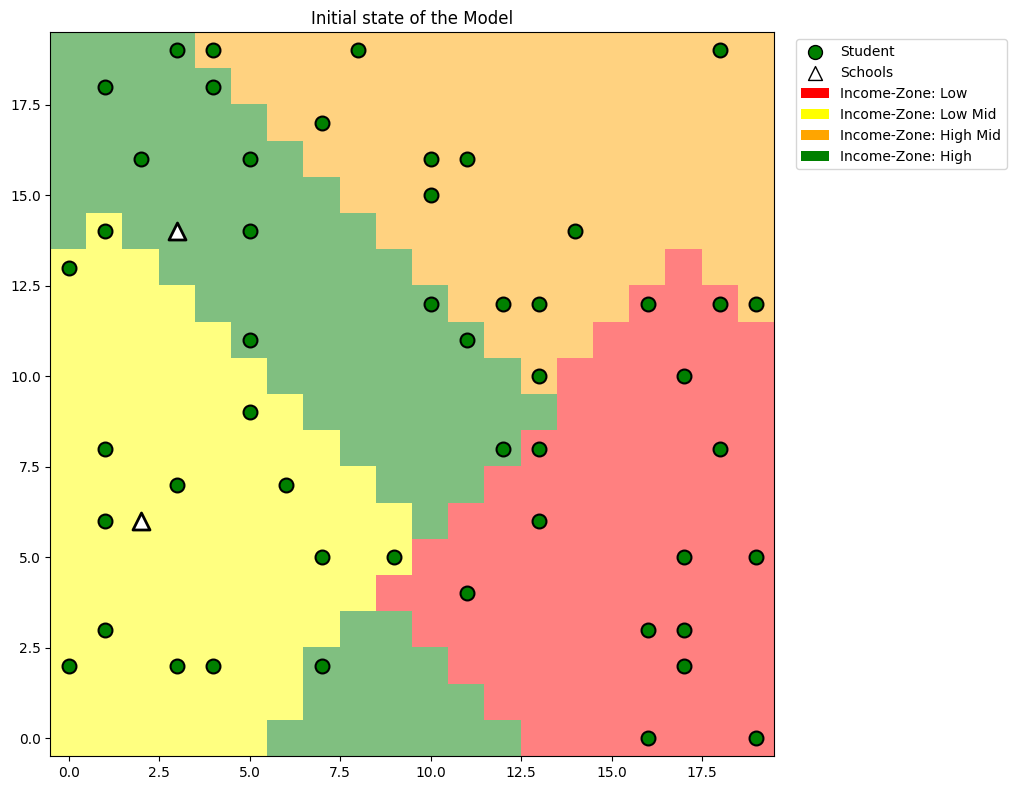

In [9]:
visualize_initial(model)

Step 1: Dropped out: 7, Rate: 14.0%


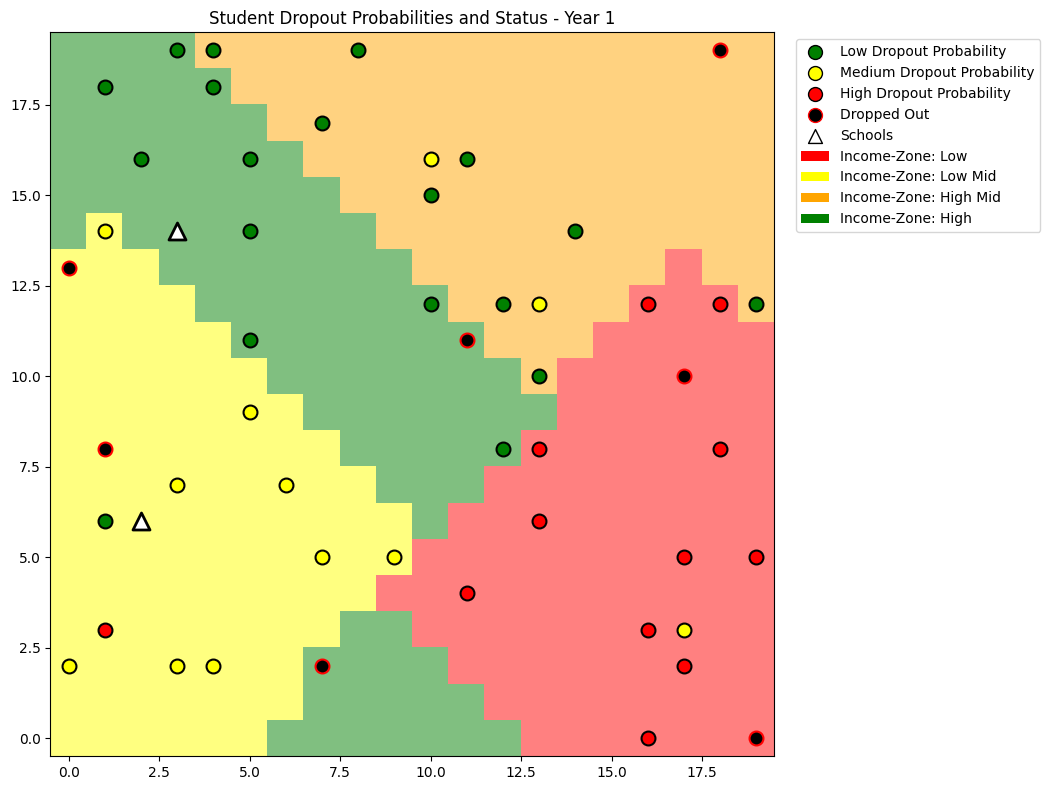

Step 2: Dropped out: 10, Rate: 20.0%


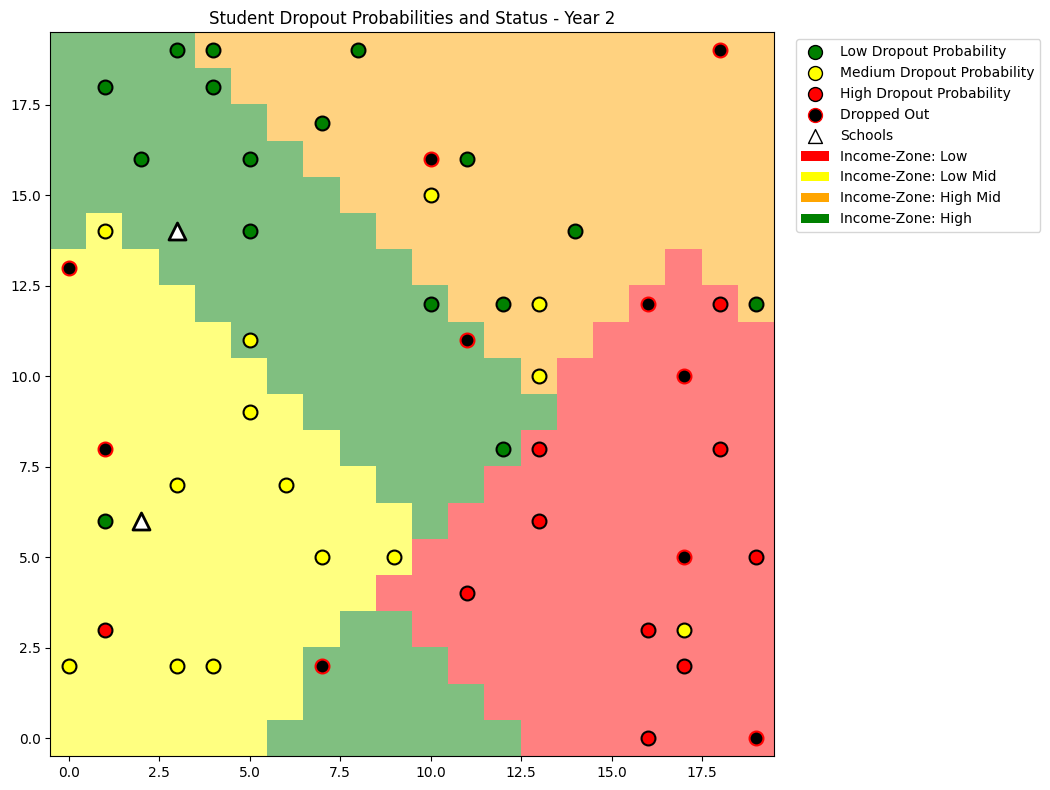

Step 3: Dropped out: 15, Rate: 30.0%


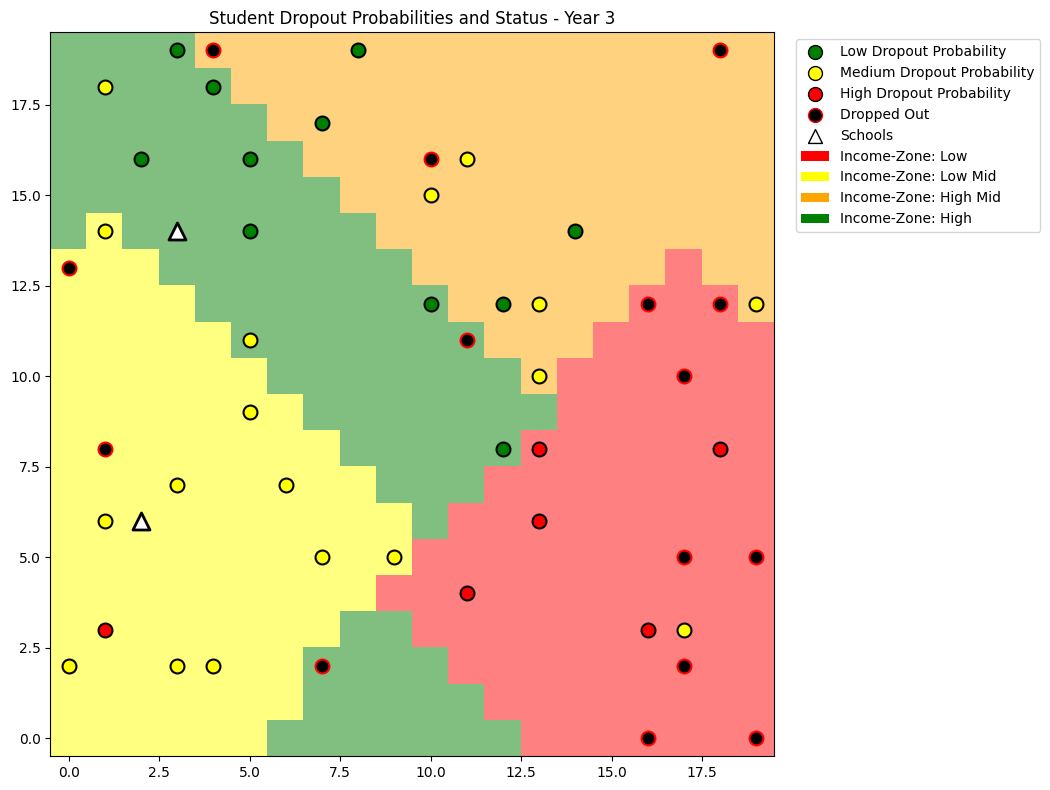

Step 4: Dropped out: 17, Rate: 34.0%


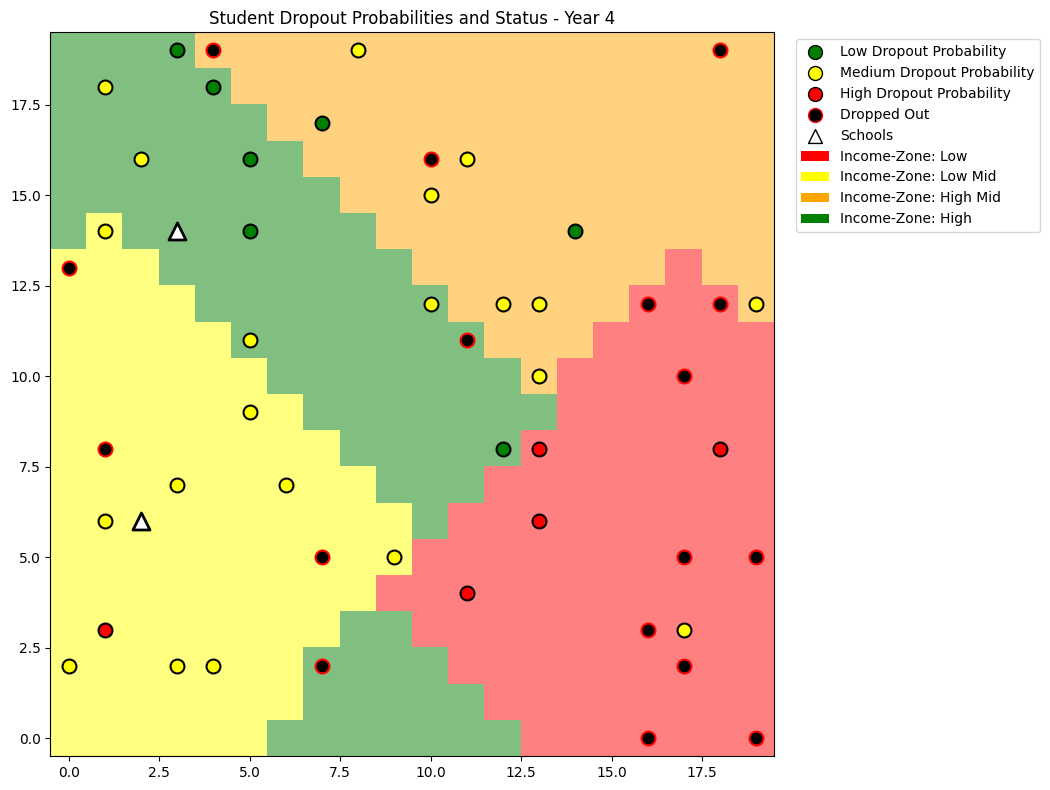

In [10]:
# model = DropOutModel(width=20, height=20, num_students=50, num_schools=2)

for step in range(4):
        model.step()
        stats = model.dropout_stat()
        print(f"Step {step+1}: Dropped out: {stats['dropped_out']}, Rate: {stats['dropout_rate_percent']:.1f}%")
        visualize(model)

In [11]:
df = student_df(model)
df

,unique_id,position_x,position_y,income_zone,iq,income_hh,education_parents,distance_school,siblings,motivation,district_wealth,parental_involvement,dropout_probability,dropped_out
0,0,17,3,low,135.655529,0,2,18,1,0.741028,0,0.543464,0.113851,False
1,1,5,14,high,95.318600,3,4,2,2,0.907623,3,0.188226,0.071617,False
2,2,5,9,low_mid,101.897256,3,1,6,3,0.075982,1,0.379137,0.125559,False
3,3,2,16,high,100.185077,3,4,3,1,0.118335,3,0.578126,0.078148,False
4,4,4,18,high,100.060065,3,4,5,1,0.636625,3,0.244216,0.072451,False
5,5,1,6,low_mid,112.803663,2,4,1,0,0.165890,1,0.584507,0.086146,False
6,6,16,3,low,81.108967,0,1,17,2,0.576911,0,0.459065,0.508187,True
7,7,16,12,low,99.973926,0,0,15,2,0.321961,0,0.490390,0.453870,True
8,8,7,17,high_mid,107.138801,3,3,7,0,0.684078,2,0.592965,0.071795,False
9,9,18,19,high_mid,94.906506,2,2,20,2,0.731325,2,0.281171,0.089508,True


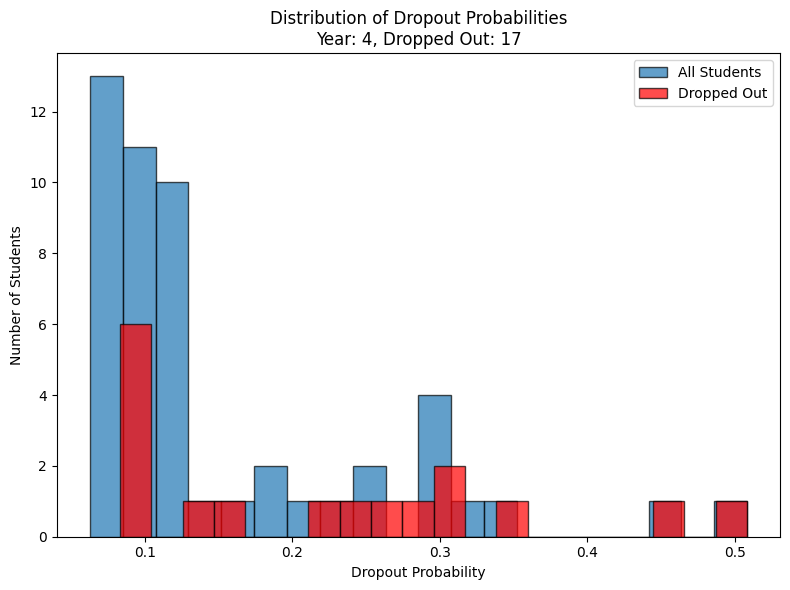

In [12]:
all_probs = df['dropout_probability']
dropped_out_probs = df[df['dropped_out'] == True]['dropout_probability']

num_dropped_out = len(dropped_out_probs)

current_step = model.steps

plt.figure(figsize=(8, 6))
plt.hist(all_probs, bins=20, edgecolor='black', alpha=0.7, label='All Students')
plt.hist(dropped_out_probs, bins=20, edgecolor='black', alpha=0.7, label='Dropped Out', color='red')

plt.title(f"Distribution of Dropout Probabilities\nYear: {current_step}, Dropped Out: {num_dropped_out}")
plt.xlabel("Dropout Probability")
plt.ylabel("Number of Students")
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
def analytics_students(width, height, num_runs, num_steps, num_students, num_schools):
    results = []
    
    for run in range(num_runs):
        model_run = DropOutModel(width, height, num_students, num_schools)

        drop_out_rates = []
        for x in range(num_steps):
            model_run.step()
            stats_step = model_run.dropout_stat()
            drop_out_rates.append(stats_step['dropout_rate_percent'])
        
        df = student_df(model_run)

        drop_out_rate_run = (df['dropped_out'] == True).sum() / len(df) * 100
        max_drop_out = max(drop_out_rates)
        min_drop_out = min(drop_out_rates)

        data_run = {
                'low_zone': df.loc[df['income_zone'] == 'low', 'income_zone'].count(),
                'low_mid_zone': df.loc[df['income_zone'] == 'low_mid', 'income_zone'].count(),
                'high_mid_zone': df.loc[df['income_zone'] == 'high_mid', 'income_zone'].count(),
                'high_zone': df.loc[df['income_zone'] == 'high', 'income_zone'].count(),
                'mean_iq': df['iq'].mean(),
                'max_iq': df['iq'].max(),
                'min_iq': df['iq'].min(),
                'low_income': df.loc[df['income_hh'] == 0, 'income_hh'].count(),
                'low_mid_income': df.loc[df['income_hh'] == 1, 'income_hh'].count(),
                'high_mid_income': df.loc[df['income_hh'] == 2, 'income_hh'].count(),
                'high_income': df.loc[df['income_hh'] == 3, 'income_hh'].count(),
                'no_education_parents': df.loc[df['education_parents'] == 0, 'education_parents'].count(),
                'primary_education_parents': df.loc[df['education_parents'] == 1, 'education_parents'].count(),
                'lower_secondary_education_parents': df.loc[df['education_parents'] == 2, 'education_parents'].count(),
                'higher_secondary_education_parents': df.loc[df['education_parents'] == 3, 'education_parents'].count(),
                'tertiary_education_parents': df.loc[df['education_parents'] == 4, 'education_parents'].count(),
                'mean_distance': df['distance_school'].mean(),
                'max_distance': df['distance_school'].max(),
                'min_distance': df['distance_school'].min(),
                'mean_siblings': df['siblings'].mean(),
                'max_siblings': df['siblings'].max(),
                'min_siblings': df['siblings'].min(),
                'mean_motivation': df['motivation'].mean(),
                'max_motivation': df['motivation'].max(),
                'min_motivation': df['motivation'].min(),
                'low_district_wealth': df.loc[df['district_wealth'] == 0, 'district_wealth'].count(),
                'low_mid_district_wealth': df.loc[df['district_wealth'] == 1, 'district_wealth'].count(),
                'high_mid_district_wealth': df.loc[df['district_wealth'] == 2, 'district_wealth'].count(),
                'high_district_wealth': df.loc[df['district_wealth'] == 3, 'district_wealth'].count(),
                'mean_parental_involvement': df['parental_involvement'].mean(),
                'max_parental_involvement': df['parental_involvement'].max(),
                'min_parental_involvement': df['parental_involvement'].min(),
                'mean_dropout_probability': df['dropout_probability'].mean(),
                'max_dropout_probability': df['dropout_probability'].max(),
                'min_dropout_probability': df['dropout_probability'].min(),
                'dropped_out': df.loc[df['dropped_out'] == True, 'dropped_out'].count(),
                'stayed': df.loc[df['dropped_out'] == False, 'dropped_out'].count(),
                'drop_out_rate': drop_out_rate_run,
                'min_drop_out_rate_step': min_drop_out,
                'max_drop_out_rate_step': max_drop_out
            }
        
        results.append(data_run)
    
    results_df = pd.DataFrame(results)
    return results_df

In [14]:
# results_df = analytics_students(width=200, height=200, num_runs=100, num_steps=4, num_students=500, num_schools=20)
results_df = analytics_students(width=20, height=20, num_runs=1000, num_steps=4, num_students=50, num_schools=2)

In [15]:
results_df

,low_zone,low_mid_zone,high_mid_zone,high_zone,mean_iq,max_iq,min_iq,low_income,low_mid_income,high_mid_income,...,max_parental_involvement,min_parental_involvement,mean_dropout_probability,max_dropout_probability,min_dropout_probability,dropped_out,stayed,drop_out_rate,min_drop_out_rate_step,max_drop_out_rate_step
0,15,15,7,13,96.880694,117.534486,63.428301,13,8,16,...,0.952858,0.002742,0.169145,0.592043,0.065444,21,29,42.0,12.0,42.0
1,12,16,13,9,100.030637,127.641126,75.760856,17,8,12,...,0.997712,0.011345,0.171665,0.695458,0.065990,21,29,42.0,18.0,42.0
2,15,7,17,11,94.952241,116.951306,70.360704,15,9,14,...,0.980846,0.021753,0.173684,0.507326,0.056791,23,27,46.0,8.0,46.0
3,9,14,12,15,98.991096,133.133771,67.243603,5,13,13,...,0.994232,0.040270,0.136255,0.711756,0.046525,14,36,28.0,6.0,28.0
4,13,12,16,9,99.974574,123.234302,75.950997,12,8,13,...,0.998345,0.002542,0.153501,0.503543,0.057546,22,28,44.0,6.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,11,13,14,12,99.071233,134.317275,69.391031,13,6,10,...,0.999716,0.022861,0.136629,0.482180,0.058151,24,26,48.0,14.0,48.0
996,9,9,11,21,99.513008,139.939168,68.560573,9,7,11,...,0.988258,0.033370,0.131796,0.425390,0.040931,17,33,34.0,14.0,34.0
997,19,14,5,12,95.353732,125.724558,65.305229,23,7,11,...,0.983991,0.026029,0.231814,0.694960,0.045704,34,16,68.0,14.0,68.0
998,9,13,11,17,100.097426,133.341894,68.757664,9,10,14,...,0.999647,0.000855,0.139974,0.529234,0.058018,23,27,46.0,10.0,46.0


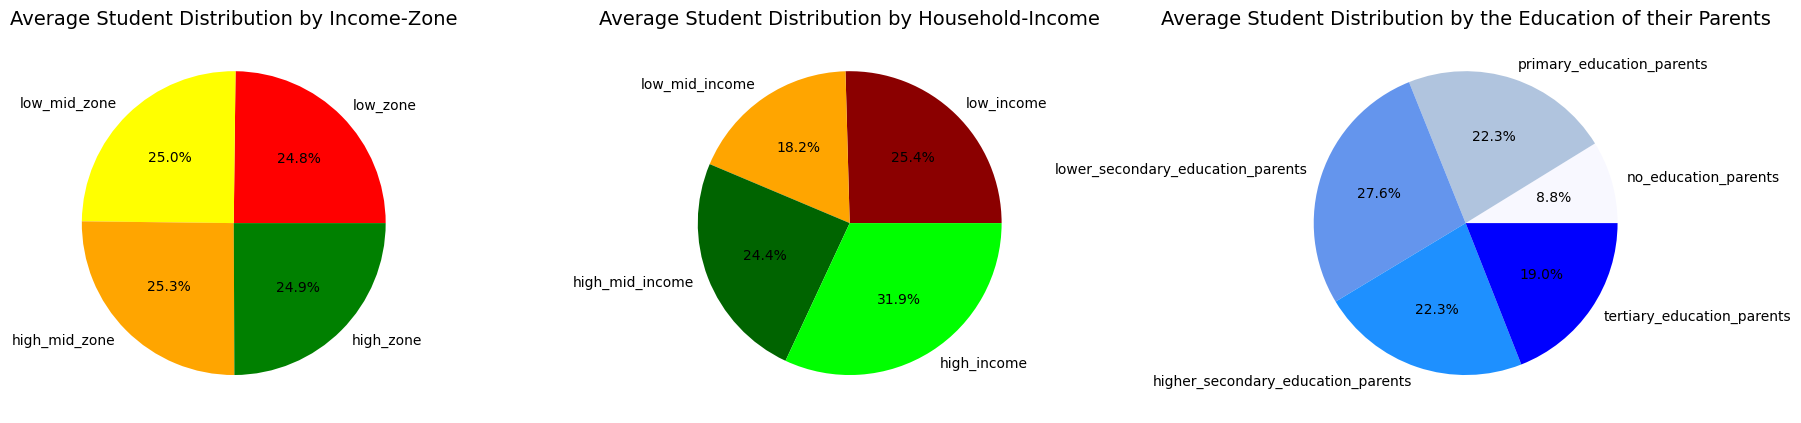

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

zone_columns = ['low_zone', 'low_mid_zone', 'high_mid_zone', 'high_zone']
zone_avg = []
for c in zone_columns:
    zone_avg.append(results_df[c].mean())

zone_colors = ['red', 'yellow', 'orange', 'green']
axes[0].pie(zone_avg, autopct='%1.1f%%', labels=zone_columns, colors=zone_colors)
axes[0].set_title('Average Student Distribution by Income-Zone', fontsize=14)

income_columns = ['low_income', 'low_mid_income', 'high_mid_income', 'high_income']
income_avg = []
for c in income_columns:
    income_avg.append(results_df[c].mean())
income_colors = ['darkred', 'orange', 'darkgreen', 'lime']
axes[1].pie(income_avg, autopct='%1.1f%%', labels=income_columns, colors=income_colors)
axes[1].set_title('Average Student Distribution by Household-Income', fontsize=14)

education_columns = ['no_education_parents', 'primary_education_parents', 'lower_secondary_education_parents', 'higher_secondary_education_parents', 'tertiary_education_parents']
education_avg = []
for c in education_columns:
    education_avg.append(results_df[c].mean())
education_colors = ['ghostwhite', 'lightsteelblue', 'cornflowerblue', 'dodgerblue', 'blue']
axes[2].pie(education_avg, autopct='%1.1f%%', labels=education_columns, colors=education_colors)
axes[2].set_title('Average Student Distribution by the Education of their Parents', fontsize=14)

plt.tight_layout()
plt.show()

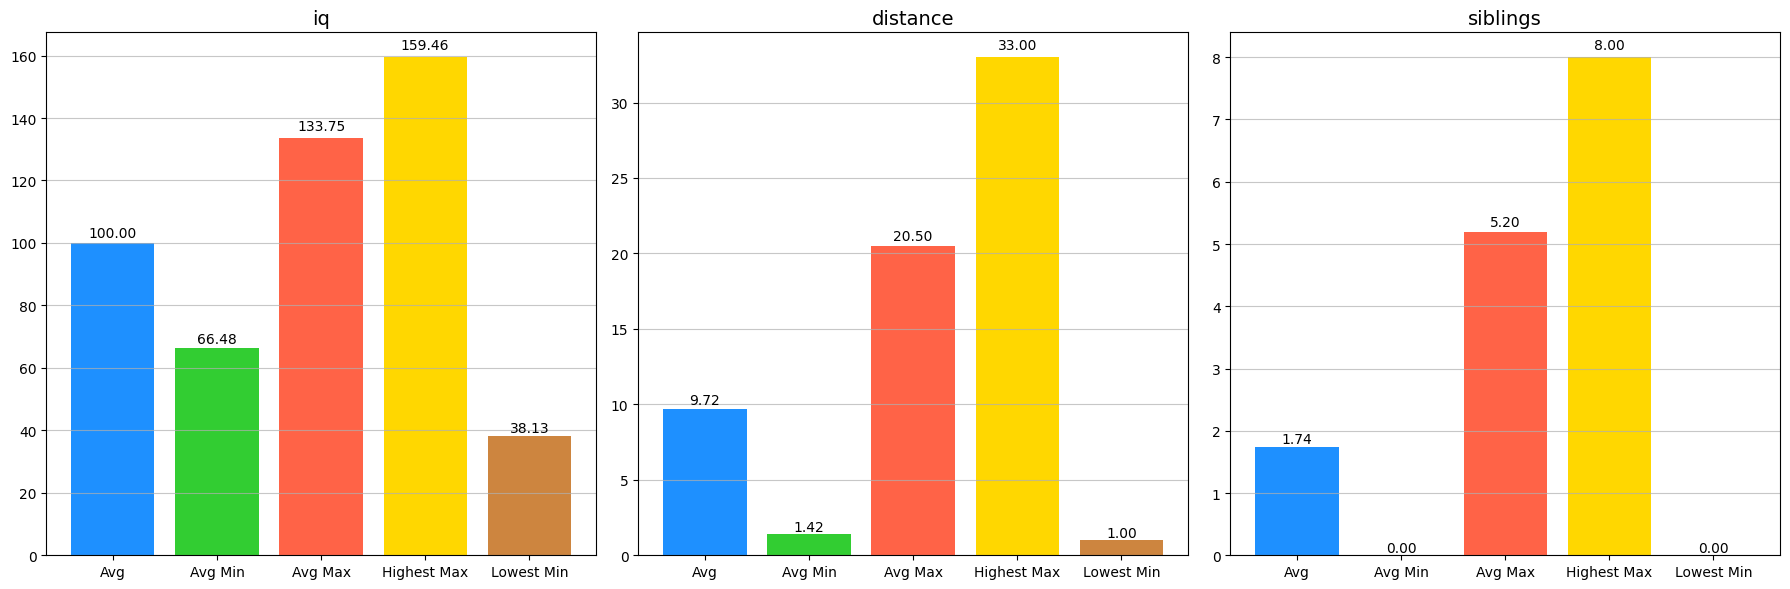

In [17]:
bar_factors = ['iq', 'distance', 'siblings'] #, 'motivation', 'district_wealth', 'parental_involvement']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()

colors = ['dodgerblue', 'limegreen', 'tomato', 'gold', 'peru']
stat_labels = ['Avg', 'Avg Min', 'Avg Max', 'Highest Max', 'Lowest Min']

for i, factor in enumerate(bar_factors):
    mean_col = f'mean_{factor}'
    min_col = f'min_{factor}'
    max_col = f'max_{factor}'
    
    statistics = [
        results_df[mean_col].mean(),
        results_df[min_col].mean(),
        results_df[max_col].mean(),
        results_df[max_col].max(),
        results_df[min_col].min()
    ]
    
    bars = axes[i].bar(stat_labels, statistics, color=colors)
    for bar, value in zip(bars, statistics):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + height*0.01, f'{value:.2f}', ha='center', va='bottom')
    
    axes[i].set_title(f'{factor}', fontsize=14)
    axes[i].grid(axis='y', alpha=0.7)

plt.tight_layout()
plt.show()

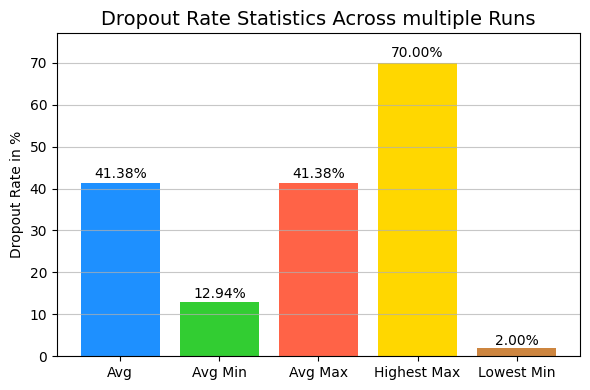

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

colors_drop = ['dodgerblue', 'limegreen', 'tomato', 'gold', 'peru']
stat_labels = ['Avg', 'Avg Min', 'Avg Max', 'Highest Max', 'Lowest Min']

statistics = [
    results_df['drop_out_rate'].mean(),
    results_df['min_drop_out_rate_step'].mean(),
    results_df['max_drop_out_rate_step'].mean(),
    results_df['max_drop_out_rate_step'].max(),
    results_df['min_drop_out_rate_step'].min()]

bars_drop = ax.bar(stat_labels, statistics, color=colors_drop)

for bar, value in zip(bars_drop, statistics):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01, f'{value:.2f}%', ha='center', va='bottom')

ax.set_title('Dropout Rate Statistics Across multiple Runs', fontsize=14)
ax.set_ylabel('Dropout Rate in %')
ax.set_ylim(0, max(statistics) * 1.1)
ax.grid(axis='y', alpha=0.7)

plt.tight_layout()
plt.show()

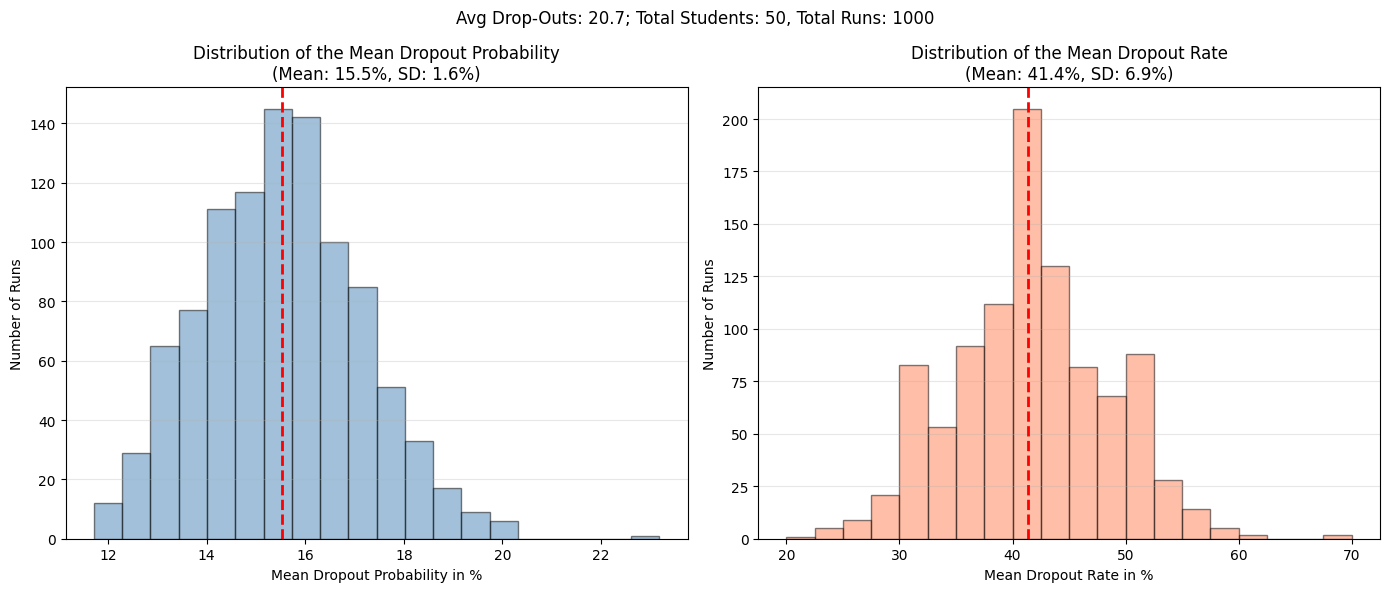

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

total_students_per_run = results_df['dropped_out'].iloc[0] + results_df['stayed'].iloc[0]
num_runs = len(results_df)
avg_dropped_out = results_df['dropped_out'].mean()

mean_dropout_prob = results_df['mean_dropout_probability']*100
avg_drop_prob = mean_dropout_prob.mean()
sd_drop_prob = mean_dropout_prob.std()

fig.suptitle(f'Avg Drop-Outs: {avg_dropped_out:.1f}; Total Students: {total_students_per_run}, Total Runs: {num_runs}')

ax1.hist(mean_dropout_prob, bins=20, color='steelblue', edgecolor='black', alpha=0.5)
ax1.set_title(f'Distribution of the Mean Dropout Probability\n(Mean: {avg_drop_prob:.1f}%, SD: {sd_drop_prob:.1f}%)')
ax1.set_xlabel('Mean Dropout Probability in %')
ax1.set_ylabel('Number of Runs')
ax1.grid(axis='y', alpha=0.3)
ax1.axvline(avg_drop_prob, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_dropped_out:.1f}%')

avg_drop_rate = results_df['drop_out_rate'].mean()
sd_drop_rate = results_df['drop_out_rate'].std()

ax2.hist(results_df['drop_out_rate'], bins=20, color='coral', edgecolor='black', alpha=0.5)
ax2.set_title(f'Distribution of the Mean Dropout Rate\n(Mean: {avg_drop_rate:.1f}%, SD: {sd_drop_rate:.1f}%)')
ax2.set_xlabel('Mean Dropout Rate in %')
ax2.set_ylabel('Number of Runs')
ax2.grid(axis='y', alpha=0.3)
ax2.axvline(avg_drop_rate, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_drop_prob:.1f}%')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

### Intervention and Simulation of alternative model

In [20]:
# Alternative model to simulate interventions to regulate the dropout rate 
# This scenario focuses on reducing barriers for household income and incentiving motivation & IQ 
class DropOutModel_Alt(Model):
    def __init__(self, width, height, num_students, num_schools):
        super().__init__()
        self.grid = SingleGrid(width, height, torus=False)
        self.width = width
        self.height = height

        self.num_students = num_students
        self.student_counter = 0

        self.num_schools = num_schools
        self.school_counter = 0
        
        self.income_zones = self.create_income_zones()
        self.place_schools()
        self.place_students()
    
    def create_income_zones(self, num_zones=4):
        total_cells = self.width * self.height
        cells_per_zone = total_cells // num_zones
        remaining_cells = total_cells % num_zones
        
        zone_sizes = [cells_per_zone] * num_zones
        for i in range(remaining_cells):
            zone_sizes[i] += 1
                
        zones = np.full((self.width, self.height), -1, dtype=int)
        
        income_names = ['low', 'low_mid', 'high_mid', 'high']
        self.zone_mapping = {i: income_names[i] for i in range(num_zones)}
        
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        
        for zone_id in range(num_zones):
            target_size = zone_sizes[zone_id]
            
            unassigned_cells = []
            for x in range(self.width):
                for y in range(self.height):
                    if zones[x, y] == -1:
                        unassigned_cells.append((x, y))
            
            if not unassigned_cells:
                break
            
            seed_x, seed_y = random.choice(unassigned_cells)
            zones[seed_x, seed_y] = zone_id
            
            queue = deque([(seed_x, seed_y)])
            current_size = 1
            
            while current_size < target_size:
                if not queue:
                    break
                
                next_queue = deque()
                expanded_this_round = False
                
                while queue and current_size < target_size:
                    x, y = queue.popleft()
                    
                    neighbors = []
                    for dx, dy in directions:
                        nx, ny = x + dx, y + dy
                        if (0 <= nx < self.width and 0 <= ny < self.height and 
                            zones[nx, ny] == -1):
                            neighbors.append((nx, ny))
                    
                    for nx, ny in neighbors:
                        if (nx, ny) not in next_queue:
                            next_queue.append((nx, ny))
                
                while next_queue and current_size < target_size:
                    nx, ny = next_queue.popleft()
                    
                    if zones[nx, ny] == -1:
                        zones[nx, ny] = zone_id
                        queue.append((nx, ny))
                        current_size += 1
                        expanded_this_round = True
                
                if not expanded_this_round:
                    break
            
        remaining_unassigned = []
        for x in range(self.width):
            for y in range(self.height):
                if zones[x, y] == -1:
                    remaining_unassigned.append((x, y))
                
        for x, y in remaining_unassigned:
            current_counts = [np.sum(zones == i) for i in range(num_zones)]
            
            zone_deficits = [(zone_sizes[i] - current_counts[i], i) for i in range(num_zones)]
            zone_deficits.sort(reverse=True)
            
            if zone_deficits[0][0] > 0:
                target_zone = zone_deficits[0][1]
                zones[x, y] = target_zone
            else:
                min_count = min(current_counts)
                target_zone = current_counts.index(min_count)
                zones[x, y] = target_zone
                
        return zones
    
    def place_schools(self):
        for schools in range(self.num_schools):
            x = random.randint(0, self.width - 1)
            y = random.randint(0, self.height - 1)
            
            if self.grid.is_cell_empty((x, y)):
                school = School(self.school_counter, self, x, y)
                self.grid.place_agent(school, (x, y))
                self.school_counter += 1
    
    def place_students(self):
        empty_cells = []
        for x in range(self.width):
            for y in range(self.height):
                if self.grid.is_cell_empty((x, y)):
                    empty_cells.append((x, y))
        
        if len(empty_cells) < self.num_students:
            num_places = len(empty_cells)
        else:
            num_places = self.num_students
        
        selected_positions = random.sample(empty_cells, num_places)
        
        for x, y in selected_positions:
            zone_id = self.income_zones[x, y]
            income_level = self.zone_mapping[zone_id]
            
            iq = np.random.normal(100, 15)
            
            if income_level == 'high':
                income_hh = np.random.choice([0, 1, 2, 3], p=[0.025, 0.025, 0.2, 0.75])
                education_parents = np.random.choice([0, 1, 2, 3, 4], p=[0.01, 0.04, 0.2, 0.25, 0.5])
                district_wealth = 3
            elif income_level == 'high_mid':
                income_hh = np.random.choice([0, 1, 2, 3], p=[0.05, 0.15, 0.4, 0.4])
                education_parents = np.random.choice([0, 1, 2, 3, 4], p=[0.05, 0.1, 0.2, 0.45, 0.2])
                district_wealth = 2
            elif income_level == 'low_mid':
                income_hh = np.random.choice([0, 1, 2, 3], p=[0.20, 0.35, 0.35, 0.1])
                education_parents = np.random.choice([0, 1, 2, 3, 4], p=[0.10, 0.35, 0.35, 0.15, 0.05])
                district_wealth = 1
            else:
                income_hh = np.random.choice([0, 1, 2, 3], p=[0.75, 0.2, 0.025, 0.025])
                education_parents = np.random.choice([0, 1, 2, 3, 4], p=[0.20, 0.40, 0.35, 0.04, 0.01])
                district_wealth = 0

            distance_school = self.calculate_distance_to_nearest_school(x, y)

            siblings = -1
            while siblings < 0:
                siblings = np.random.normal(2.0566, 1.60256)
                siblings = int(siblings)
                
            motivation = np.random.uniform(0, 1)
            parental_involvement = np.random.uniform(0, 1)

            student = Student(
                self.student_counter,
                self,
                iq,
                income_hh,
                education_parents,
                distance_school,
                siblings,
                motivation,
                district_wealth,
                parental_involvement,
                False)

            self.grid.place_agent(student, (x, y))
            self.student_counter += 1
        
    def calculate_distance_to_nearest_school(self, x, y):
        min_distance = float('inf')
        
        for agent in self.grid.coord_iter():
            agent_obj, (ax, ay) = agent
            if isinstance(agent_obj, School):
                distance = abs(x - ax) + abs(y - ay)
                min_distance = min(min_distance, distance)
    
        return min_distance if min_distance != float('inf') else 0
    
    # base dropout
    def step(self, base_drop_out=0.1):
        for agent in self.grid.coord_iter():
            agent_obj, (x, y) = agent
            if hasattr(agent_obj, 'factors') and not agent_obj.dropped_out:
                f = agent_obj.factors

                weights = {
                    'iq': 8,                    # Increased from 6 to 8
                    'income_hh': 4,             # Reduced from 8 to 4
                    'education_parents': 8,
                    'siblings': 2,
                    'motivation': 8,            # Increased from 4 to 8
                    'distance_school': 3,
                    'district_wealth': 3,
                    'parental_involvement': 4
                }
                total_weight = sum(weights.values())

                impacts = {
                    'iq': ((100 - min(max(f['iq'], 70), 130)) / 30),  
                    'income_hh': 1 - (f['income_hh'] / 3),          
                    'education_parents': 1 - (f['education_parents'] / 4),
                    'siblings': 0.5 + min(f['siblings'] / 10, 0.5),                 
                    'motivation': 1 - f['motivation'],               
                    'distance_school': min(f['distance_school'] / 50, 1),  
                    'district_wealth': 1 - (f['district_wealth'] / 3),     
                    'parental_involvement': 1 - f['parental_involvement']  
                }

                for k in impacts:
                    impacts[k] = (impacts[k] - 0.5) * 2

                # weighted sum of impacts
                total_impact = sum(weights[k] * impacts[k] for k in impacts) / total_weight

                # assymetric scaling
                if total_impact < 0:
                    adjustment = total_impact * base_drop_out
                else:
                    adjustment = total_impact * (1 - base_drop_out)
                drop_out_prob = base_drop_out + adjustment

                # step adjustment
                drop_out_prob += 0.01 * self.steps
                drop_out_prob = max(0, min(1, drop_out_prob)) 

                agent_obj.dropout_prob = drop_out_prob

                choice = np.random.choice([True, False], p=[drop_out_prob, 1 - drop_out_prob])
                if choice:
                    agent_obj.dropped_out = True

    def dropout_stat(self):
        total_students = 0
        dropped_out = 0
        
        for agent in self.grid.coord_iter():
            agent_obj, (x, y) = agent
            if hasattr(agent_obj, 'factors'):
                total_students += 1
                if agent_obj.dropped_out:
                    dropped_out += 1
        
        if total_students > 0:
            dropout_rate = (dropped_out / total_students) * 100
        else:
            dropout_rate = 0
        
        dict_stat = {
            'total_students': total_students,
            'dropped_out': dropped_out,
            'students_active': total_students - dropped_out,
            'dropout_rate_percent': dropout_rate}
        
        return dict_stat

In [21]:
def run_simulation(ModelClass, width, height, num_students, num_schools, steps=4):
    model = ModelClass(width, height, num_students, num_schools)
    for _ in range(steps):
        model.step()
    stats = model.dropout_stat()
    return stats['dropout_rate_percent']

In [22]:
num_runs = 1000
steps = 4

original_results = []
alternative_results = []

for i in range(num_runs):
    dropout_orig = run_simulation(DropOutModel, 20, 20, 200, 5, steps)
    dropout_alt = run_simulation(DropOutModel_Alt, 20, 20, 200, 5, steps)

    original_results.append(dropout_orig)
    alternative_results.append(dropout_alt)


In [23]:
avg_orig = np.mean(original_results)
std_orig = np.std(original_results)

avg_alt = np.mean(alternative_results)
std_alt = np.std(alternative_results)

print(f"Original Model: Mean dropout = {avg_orig:.2f}%, Std = {std_orig:.2f}")
print(f"Alternative Model: Mean dropout = {avg_alt:.2f}%, Std = {std_alt:.2f}")

Original Model: Mean dropout = 41.28%, Std = 3.35
Alternative Model: Mean dropout = 38.39%, Std = 3.44


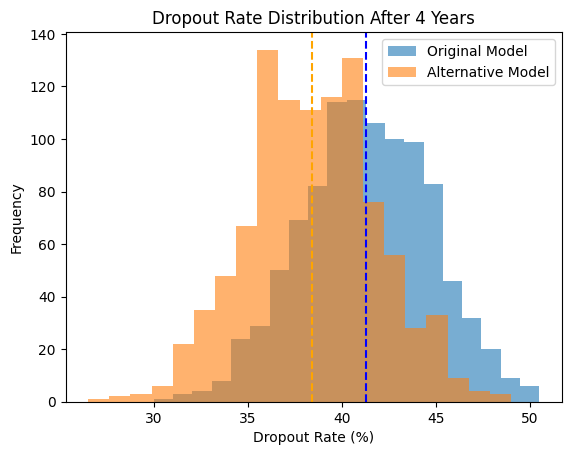

In [24]:
plt.hist(original_results, bins=20, alpha=0.6, label='Original Model')
plt.hist(alternative_results, bins=20, alpha=0.6, label='Alternative Model')
plt.axvline(avg_orig, color='blue', linestyle='--')
plt.axvline(avg_alt, color='orange', linestyle='--')
plt.title("Dropout Rate Distribution After 4 Years")
plt.xlabel("Dropout Rate (%)")
plt.ylabel("Frequency")
plt.legend()
plt.show()